# Sales Forecasting

Autore: [Alessandro D'Orazio](https://alessandrodorazio.it) per [parliamodiai.it](https://parliamodiai.it)

In questo notebook, viene mostrato il funzionamento di un sistema molto semplice per la previsione delle vendite.

Partendo da un dataset contenente le vendite mensili, l'obiettivo sarà quello di predire le vendite future.<br>
Più tecnicamente, utilizzeremo un'architettura [LSTM (Long Short-Term Memory)](https://en.wikipedia.org/wiki/Long_short-term_memory), cioè una tipologia di rete neurale molto efficace nell'elaborazione di dati temporali.

In [1]:
# importazione delle librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

# Preprocessamento dei dati

Il dataset utilizzato è composto da due colonne: `Timestamp` e `Sales Amount (USD)`.<br>
Per comodità, modificheremo il nome della colonna `Sales Amount (USD)` in `sales`.

| Timestamp | Sales Amount (USD) |
|-----------|--------------------|
|2000-01-01|1000|
|2000-02-01|1100|
|2000-03-01|1050|
|2000-04-01|1200|
|2000-05-01|1150|


In [2]:
df = pd.read_csv('sales.csv', parse_dates=['Timestamp']) # trattiamo il Timestamp come una data
df.rename(columns={'Sales Amount (USD)': 'sales'}, inplace=True)
df.set_index('Timestamp', inplace=True) # utilizziamo la data come indice del DataFrame
df

,sales
Timestamp,
2000-01-01,1000
2000-02-01,1100
2000-03-01,1050
2000-04-01,1200
2000-05-01,1150
...,...
2030-10-01,19450
2030-11-01,19500
2030-12-01,19550


# Rappresentazione grafica nel tempo

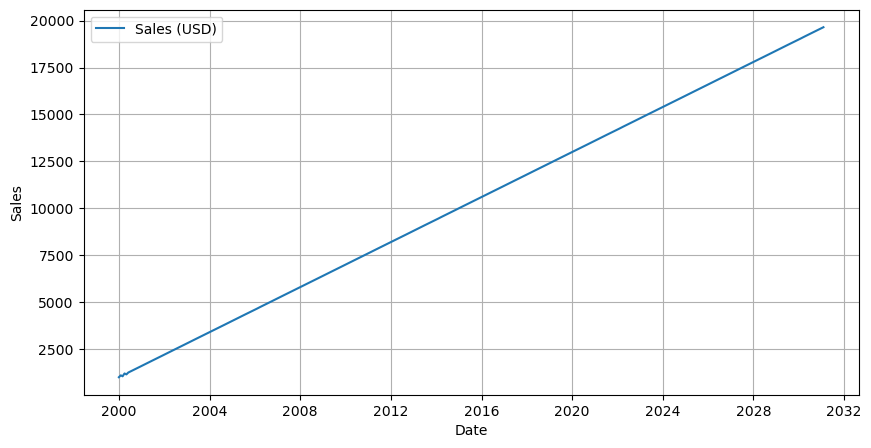

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['sales'], label='Sales (USD)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

## Analisi del grafico

Possiamo già notare un trend molto positivo. <br>
Questo ci fa pensare che, non considerando altri fattori (es. tendenze macroeconomiche), le vendite continueranno a salire nel tempo.

# Normalizzazione dei dati

Le reti neurali LSTM sono molto sensibili alla scala di valori utilizzata. In questo caso abbiamo dei valori compresi tra 1000 e 19650. L'ideale sarebbe avere un range di valori più piccolo.

Utilizziamo quindi uno strumento chiamato `Scaler` che imposterà (in questo caso)  0 come il valore più basso e 1 come il valore più alto, e renderà relativi gli altri numeri, che saranno quindi sempre compresi tra 0 e 1. Questa tipologia di Scaler è chiamata [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['sales'] = scaler.fit_transform(df['sales'].values.reshape(-1,1))
df

,sales
Timestamp,
2000-01-01,0.000000
2000-02-01,0.005362
2000-03-01,0.002681
2000-04-01,0.010724
2000-05-01,0.008043
...,...
2030-10-01,0.989276
2030-11-01,0.991957
2030-12-01,0.994638


# Creazione del dataset

Prima di creare il modello, dobbiamo creare un dataset che sia compatibile con la rete LSTM.<br>
Creiamo quindi un'array contenente una lista di sequenze di vendita.<br>
Considerando le prime 5 righe del dataset, le vendite sono state di 1000, 1100, 1050, 1200 e 1150.

Dobbiamo ora generare un'insieme di sequenze di vendita da fornire al modello per l'addestramento.<br>
Per farlo, definiamo prima quanto ogni sequenza debba essere lunga. In questo caso utilizzeremo un periodo di 3 mesi (look back).

Definiamo $X_i$ come la sequenza di vendite precedenti al mese $i$, e $Y_i$ come la vendita nel mese $i$. <br>
Non possiamo calcolare la sequenza di vendite dei primi tre mesi (non avendone i dati), quindi partiamo dal quarto mese di vendita, cioè il primo di cui conosciamo l'andamento dei 3 mesi precedenti.

Il dataset per l'addestramento dovrà dunque essere così formato:


$X_0=[1000, 1100, 1050], Y_0=1200$

$X_1=[1100, 1050, 1200], Y_1=1150$

e così via...

In [5]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 3
X, Y = create_dataset(df['sales'].values, look_back)

## Adattiamo i dati per Keras

Possiamo creare a questo punto un dataset che sia compatibile con il formato richiesto da Keras.

In particolare, dobbiamo formattarlo in modo tale che l'input del modello abbia la seguente forma: 

$$(numero\ dei\ sample,\ numero\ degli\ step\ di\ tempo,\ numero\ delle\ features)$$


Abbiamo 3 step di tempo per ogni sequenza, ed una sola feature, cioè le vendite.

Abbiamo 371 sample ($=\#righe\ dataset - \#step\ di\ tempo = 374-3=371$)

Ne consegue che la nuova forma dell'array dovrà essere, in questo caso, (371, 3, 1).

In [6]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(371, 3, 1)

# Creiamo i dataset di training e di test

Per farlo, utilizzeremo l'80% iniziale del dataset per il training, ed il restante 20% per il test.

In [7]:
test_size=0.2
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=test_size)

In [8]:
print(f'Dimensione del dataset per il training: {len(trainX)}')

Dimensione del dataset per il training: 296


# Creazione del modello

A questo punto possiamo creare il modello, che sarà composto da due layer.

Il primo layer sarà un LSTM, che si occuperà di processare i dati sequenziali. Il layer LSTM ritornerà come output un vettore contenente le caratteristiche (feature) imparate.<br>
Il layer LSTM avrà 32 `units`, cioè la dimensionalità dello spazio dell'output. In pratica, le units sono il numero di celle capaci di processare sequenze di dati. Avere tante units permette al modello di imparare a riconoscere più pattern, ma richiede più tempo e più dati per l'addestramento.<br>
L'`input shape` invece dice al modello quale sarà la forma del singolo input (= una riga del dataset), che nel nostro caso è $(look\ back,\ features)=(3,1)$

Il secondo layer, chiamato Dense, servirà per mappare la rappresentazione dall'output dell'LSTM all'output della forma desiderata. Avrà come parametro 1, cioè predire solamento un singolo valore (in questo caso il mese successivo). Quindi, trasformerà l'output del layer LSTM (vettore) in un singolo valore.

Infine, andiamo ad utilizzare il mean squared error come loss function, ed addestriamo il modello con il training dataset, utilizzando 100 epoche.

In [9]:
units = 32
input_shape = (look_back, 1)

model = Sequential()
model.add(LSTM(units, input_shape=input_shape))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Addestramento del modello

Ora che i layer del modello sono stati inseriti, possiamo addestrarlo utilizzando il training dataset creato precedentemente.

Impostiamo 50 come il numero di `epochs`, cioè il numero di volte che il modello dovrà passare sul training dataset.

Impostiamo 4 come `batch size`, cioè il numero di elementi del training dataset su cui dovrà passare prima di aggiornare i pesi del modello. In questo modo, i pesi saranno aggiornati ogni 4 elementi. Questo significa che ogni epoch avrà $296/4=74$ iterazioni, poiché il training dataset ha 296 elementi.

Il parametro `verbose` serve per definire quante informazioni durante il processo di addestramento mostrare come log all'utente.

In [10]:
epochs = 50
batch_size = 4
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/50
74/74 - 1s - loss: 0.0984 - 527ms/epoch - 7ms/step
Epoch 2/50
74/74 - 0s - loss: 0.0105 - 50ms/epoch - 675us/step
Epoch 3/50
74/74 - 0s - loss: 0.0026 - 47ms/epoch - 635us/step
Epoch 4/50
74/74 - 0s - loss: 4.7740e-04 - 46ms/epoch - 624us/step
Epoch 5/50
74/74 - 0s - loss: 2.5732e-04 - 47ms/epoch - 636us/step
Epoch 6/50
74/74 - 0s - loss: 2.3725e-04 - 47ms/epoch - 638us/step
Epoch 7/50
74/74 - 0s - loss: 2.0484e-04 - 48ms/epoch - 652us/step
Epoch 8/50
74/74 - 0s - loss: 1.8735e-04 - 47ms/epoch - 634us/step
Epoch 9/50
74/74 - 0s - loss: 1.6339e-04 - 46ms/epoch - 618us/step
Epoch 10/50
74/74 - 0s - loss: 1.4818e-04 - 47ms/epoch - 631us/step
Epoch 11/50
74/74 - 0s - loss: 1.2009e-04 - 48ms/epoch - 646us/step
Epoch 12/50
74/74 - 0s - loss: 1.0668e-04 - 48ms/epoch - 643us/step
Epoch 13/50
74/74 - 0s - loss: 8.3768e-05 - 47ms/epoch - 639us/step
Epoch 14/50
74/74 - 0s - loss: 7.2795e-05 - 47ms/epoch - 632us/step
Epoch 15/50
74/74 - 0s - loss: 5.4852e-05 - 47ms/epoch - 630us/step
Ep

# Valutazione del modello

Prima di procedere con la valutazione del modello, facciamo predire al modello i risultati sia utilizzando il dataset di training (che già conosce), sia il dataset di test (che non ha mai visto).

Inoltre, ritrasformiamo i valori da scalati (range 0-1) a non scalati.

In [11]:
# predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# inverse transform
trainPredictScaled = scaler.inverse_transform(trainPredict)
trainYScaled = scaler.inverse_transform([trainY])
testPredictScaled = scaler.inverse_transform(testPredict)
testYScaled = scaler.inverse_transform([testY])

3/3 [==============================] - 0s 899us/step


Passiamo ora alla valutazione del modello effettiva.

Partiamo dalle tre misure fondamentali. <br>
$x_i$ è il valore reale, mentre $y_i$ è il valore predetto dal modello.

## [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error)

$$MAE=\frac{\sum_{i=1}^n{|y_i-x_i|}}{n}$$

Il Mean Absolute Error è la media della differenza (assoluta) tra il valore predetto dal modello ed il valore reale.

Questo significa che, più sarà alto il suo valore, più il modello avrà predizioni lontane dal risultato reale. Al contrario, avere un MAE basso (tendente allo zero) implica una fedeltà più vicina alla realtà.

## [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error)

Il Mean Squared Error misura la media del quadrato degli errori.

$$MSE=\frac 1 n \sum_{i=1}^n{(x_i-y_i)}^2$$

Il vantaggio di questa misurazione è che, al contrario del MAE, l'MSE è più sensibile agli outliers (anomalie). Questo significa che, per esempio, avendo un MAE basso ed un MSE alto, allora potrebbe indicare che il modello sia nella maggior parte delle predizioni accurato, ma che ci sono alcune anomalie che distorcono l'errore verso l'alto.

## [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

Il Root Mean Squared Errors è la radice quadrata dell'MSE.

$$RMSE=\sqrt{MSE}$$

Essendo che l'MSE è data dalla media di una somma in cui tutti i termini sono al quadrato, l'RMSE "riporta" i valori nella scala originaria. <br>
Tipicamente, se l'RMSE è "vicino" al MAE, questo significa che gli errori sono distribuiti uniformemente e sono piccoli. <br>
Se l'RMSE è molto più grande del MAE, significa solitamente che ci sono degli errori di predizione molto grandi in alcuni casi.

In [12]:
trainMAE = mean_absolute_error(trainYScaled[0], trainPredictScaled[:,0])
testMAE = mean_absolute_error(testYScaled[0], testPredictScaled[:,0])

trainMSE = mean_squared_error(trainYScaled[0], trainPredictScaled[:,0])
testMSE = mean_squared_error(testYScaled[0], testPredictScaled[:,0])

trainRMSE = np.sqrt(trainMSE)
testRMSE = np.sqrt(testMSE)

print(f'Train MAE: {trainMAE}, Test MAE: {testMAE}')
print(f'Train MSE: {trainMSE}, Test MSE: {testMSE}')
print(f'Train RMSE: {trainRMSE}, Test RMSE: {testRMSE}')

Train MAE: 28.405881727063967, Test MAE: 27.86001139322907
Train MSE: 1259.1562033942519, Test MSE: 1439.545907013215
Train RMSE: 35.48459106984681, Test RMSE: 37.94134824980809


Abbiamo un MAE di circa 28 per il training dataset e di circa 27 per il testing dataset. Questo significa che le predizioni hanno solitamente un errore tra i 27 e i 28 dollari. Considerando che i valori sono compresi tra 1000 e 19650, possiamo dire che il modello non si discosta troppo dali valori reali.

L'RMSE (35) è poco superiore al MAE, dunque c'è qualche sequenza di dati anomala, ma nella stragrande maggioranza dei casi il modello è robusto anche in caso di anomalie.

# Predizioni vs valori attuali

Andiamo ora a visualizzare il grafico in cui vengono comparati i valori predetti e gli attuali sia nel training dataset che nel test dataset. <br>
In blu, saranno mostrati i valori attuali, e in rosso i valori predetti.

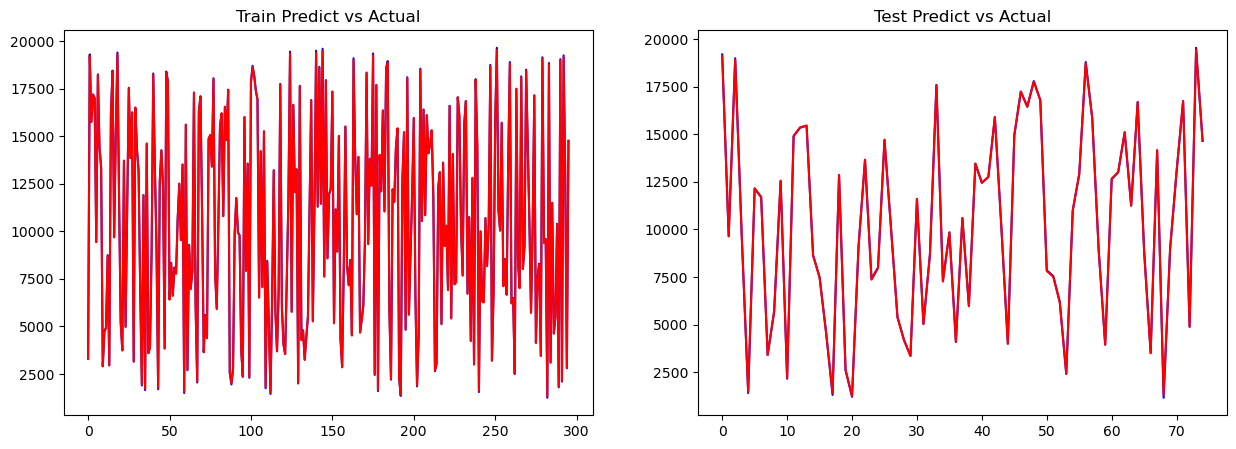

In [13]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(trainYScaled[0], color='blue')
plt.plot(trainPredictScaled[:,0], color='red')
plt.title('Train Predict vs Actual')

plt.subplot(1, 2, 2)
plt.plot(testYScaled[0], color='blue')
plt.plot(testPredictScaled[:,0], color='red')
plt.title('Test Predict vs Actual')

plt.show()

Da quel che possiamo vedere, entrambi i grafici hanno le due linee molto vicine (il blu infatti si vede solamente in qualche estremità). Questo conferma che il modello sta effettuando delle predizioni abbastanza fedeli alla realtà.

# Residual Plot

Utilizziamo ora un altro strumento, chiamato "Residual Plot", che serve per mostrare, all'interno di un grafico, la differenza tra i valori reali e quelli predetti.

Per esempio, se il modello ha predetto il valore 30, ma doveva predire invece il valore 40, ci sarà un punto nel grafico $40-30=10$.

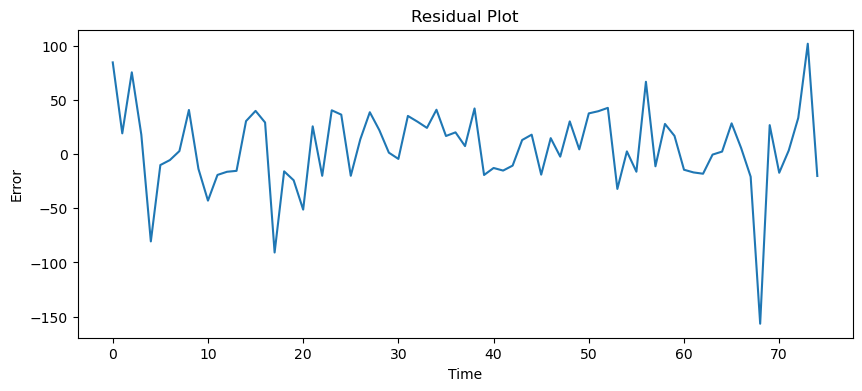

In [14]:
residuals = testYScaled[0] - testPredictScaled[:,0]
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

Possiamo quindi vedere graficamente che il modello predice le vendite nella maggior parte dei casi sbagliando di circa 50$, sia in eccesso che in difetto.

Terminiamo ora con le ultime due analisi.

# [R$^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination)

L'R$^2$ è una misura che dice quale percentuale della varianza nella variabile dipendente (vendita di un mese) è prevedibile dalle variabili indipendenti (sequenze dei mesi precedenti).

Il suo range va da 0 a 1. I valori tendenti a 1 indicano che il modello si adatta bene ai dati, mentre un valore vicino allo 0 significa che il modello "non riesce a spiegare" le differenze nelle vendite.

# [Explained Variance](https://fastercapital.com/keyword/explained-variance.html)

L'explained variance misura quanto della variazione nei dati può essere spiegata dal modello, dunque quanto le variabili indipendenti influenzano la variabile dipendente.

Se il modello predice i valori perfettamente, allora l'explained variance sarà uguale a 1.<br>
Più si allontana dal valore 1 (verso il basso), più il modello tende a fornire dei valori poco accurati.

In [15]:
testY_transformed = scaler.inverse_transform(testY.reshape(-1, 1))
r2 = r2_score(testY_transformed, testPredictScaled)
explained_variance = explained_variance_score(testY_transformed, testPredictScaled)

print(f'R-squared: {r2}')
print(f'Explained Variance: {explained_variance}')

R-squared: 0.9999456126640832
Explained Variance: 0.9999468460617047
